In [16]:
# Import libraries
import cv2
from matplotlib import pyplot as plt
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
import re
import numpy as np
import pandas as pd
import torch
from sklearn.metrics import log_loss, roc_auc_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

from deepctr_torch.inputs import SparseFeat, DenseFeat, get_feature_names
from deepctr_torch.models import *

# Download thumbnails
import time
import requests
from requests.adapters import HTTPAdapter, Retry
import json
import os
import glob
import argparse


def calculate_list_reward(permutation, alpha=0.5, beta=0.5):
    s = [1]
    for i in range(1, len(permutation)):
        s_i = 1
        for j in range(0, i):
            p_effective_view = permutation[j][1][1]
            s_i *= p_effective_view
        s.append(s_i)

    list_reward = 0
    for i in range(len(permutation)):
        reward = s[i] * (alpha * permutation[0][1][0] + beta * permutation[0][1][2])
        list_reward += reward

    return list_reward


def get_indices_from_permutation(permutation):
    indices = []
    for pair in permutation[0]:
        indices.append(pair[0])
    return indices


def get_list_reward_from_permutation(permutation):
    return permutation[1]


def calculate_stability_from_beam_scores(beam_scores):
    return min(beam_scores) / max(beam_scores)


def create_a_series_with_filled_candidates_and_empty_target_features(watched_candidates_indices, beam_indices, candidate_features_list, many_candidate_features_column_names,
                                                                     target_features_column_names):
    temp = df_train.iloc[0, :].copy()
    temp[target_features_column_names] = 0
    row_series_with_empty_candidates_and_target_features = temp

    # Fill watched candidate
    for watched_candidate_position, watched_candidate_index in enumerate(watched_candidates_indices, start=0):
        # Fill candidate videos' features
        candidate_features_column_names = many_candidate_features_column_names[watched_candidate_position]
        candidate_features_value = candidate_features_list[watched_candidate_index]
        row_series_with_empty_candidates_and_target_features[candidate_features_column_names] = candidate_features_value

    unfilled_candidate_position = len(watched_candidates_indices)

    for candidate_position, beam_index in enumerate(beam_indices, start=unfilled_candidate_position):
        # Fill candidate videos' features
        candidate_features_column_names = many_candidate_features_column_names[candidate_position]
        candidate_features_value = candidate_features_list[beam_index]
        row_series_with_empty_candidates_and_target_features[candidate_features_column_names] = candidate_features_value

    return row_series_with_empty_candidates_and_target_features


def create_input(target_video_indices, a_series_with_filled_candidates_and_empty_target_features, candidate_features_list):
    df_empty = pd.DataFrame(columns=columns_without_uid)
    # Fill target video features
    for target_video_index in target_video_indices:
        target_features_value = candidate_features_list[target_video_index][:3]
        a_series_with_filled_candidates_and_empty_target_features[target_features_column_names] = target_features_value
        df_empty = df_empty.append(a_series_with_filled_candidates_and_empty_target_features)

    df_new = df_empty
    model_input = {name: df_new[name] for name in feature_names}
    return model_input


def download_thumbnail(url):
    video_id = re.findall('(?<=video\/)(.*?)(?=\?)', url)[0]

    headers = {
            'sec-ch-ua': '"Not?A_Brand";v="8", "Chromium";v="108", "Microsoft Edge";v="108"',
            'Referer': 'https://snaptik.app/',
            'DNT': '1',
            'sec-ch-ua-mobile': '?0',
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/108.0.0.0 Safari/537.36 Edg/108.0.1462.54',
            'sec-ch-ua-platform': '"Windows"',
    }

    response = requests.get(
            f'https://www.tiktok.com/oembed?url=https://www.tiktok.com/@tiktok/video/{video_id}',
            headers=headers,
    )

    vid_info = json.loads(response.text)
    thumb_url = vid_info['thumbnail_url']
    thumb_fname = f"{THUMBNAILS_PATH}/{video_id}.png"
    # print(thumb_fname)
    r = requests.get(thumb_url)
    with open(thumb_fname, 'wb') as outfile:
        outfile.write(r.content)

    print(f'Video id: {video_id} => Done')
    return thumb_fname


def draw_green_bbox(ax):
    fig = ax.get_figure()
    # Convert bottom-left and top-right to display coordinates
    x0, y0 = ax.transAxes.transform((0, 0))
    x1, y1 = ax.transAxes.transform((1, 1))
    # Convert back to Axes coordinates
    x0, y0 = ax.transAxes.inverted().transform((x0, y0))
    x1, y1 = ax.transAxes.inverted().transform((x1, y1))
    rect = plt.Rectangle(
            (x0, y0), x1 - x0, y1 - y0,
            color='g',
            transform=ax.transAxes,
            zorder=-1,
            lw=2 * 4 + 1,
            fill=None,
    )
    fig.patches.append(rect)


def display_candidate_thumbnails(new_candidate_order, many_thumbnail_paths, watched_candidates_indices):
    index_of_next_video_to_show = new_candidate_order[0]

    for _ in watched_candidates_indices:
        new_candidate_order = [-1] + new_candidate_order

    # create figure
    fig = plt.figure(figsize=(10, 7))

    # setting values to rows and column variables
    rows = 1
    columns = 5
    # reading images
    images = []
    for index in new_candidate_order:
        if index == -1:
            image = cv2.imread(blank_image_path)
        else:
            image = cv2.imread(many_thumbnail_paths[index])
            image = image[:, :, ::-1]
        images.append(image)

    # Showing image
    for index, image in enumerate(images, start=1):
        ax = fig.add_subplot(rows, columns, index)

        if index - 1 == len(watched_candidates_indices):
            draw_green_bbox(ax)

        plt.imshow(image)
        plt.axis('off')
        if index == 5:
            break

In [9]:
THUMBNAILS_PATH = 'thumbnails_for_demo'
MODEL_PATH = "model.pth"
MODEL_PATH = r'C:\Users\MSI I5\PycharmProjects\Short-Video-Recommendation\model_output\autodis_tranformer\model.pth'
# MODEL_PATH = r'C:\Users\MSI I5\PycharmProjects\Short-Video-Recommendation\model_output\no_autodis\model.pth'

columns = ["uid", "w1_duration", "w1_num_likes", "w1_num_comments", "w1_watched_time", "w1_like", "w2_duration", "w2_num_likes", "w2_num_comments", "w2_watched_time", "w2_like", "w3_duration",
           "w3_num_likes", "w3_num_comments", "w3_watched_time", "w3_like", "w4_duration", "w4_num_likes", "w4_num_comments", "w4_watched_time", "w4_like", "w5_duration", "w5_num_likes",
           "w5_num_comments",
           "w5_watched_time", "w5_like", "w6_duration", "w6_num_likes", "w6_num_comments", "w6_watched_time", "w6_like", "w7_duration", "w7_num_likes", "w7_num_comments", "w7_watched_time", "w7_like",
           "w8_duration", "w8_num_likes", "w8_num_comments", "w8_watched_time", "w8_like", "w9_duration", "w9_num_likes", "w9_num_comments", "w9_watched_time", "w9_like", "w10_duration",
           "w10_num_likes", "w10_num_comments", "w10_watched_time", "w10_like", "c1_duration", "c1_num_likes", "c1_num_comments", "c2_duration", "c2_num_likes", "c2_num_comments", "c3_duration",
           "c3_num_likes", "c3_num_comments", "c4_duration", "c4_num_likes", "c4_num_comments", "t1_duration", "t1_num_likes", "t1_num_comments", "p_like", "p_has_next", "p_effective_view",
           "target_url"]

df_train = pd.read_csv('dataset/final_input/final_train.csv', header=0)
df_test = pd.read_csv('dataset/final_input/final_test_with_urls.csv', header=0)

df_train = df_train.drop(['uid'], axis=1)
df_test = df_test.drop(['uid'], axis=1)
columns.remove('uid')

target_urls = df_test['target_url'].tolist()
columns.remove('target_url')

sparse_features = [f'w{i}_like' for i in range(1, 11)]
target = ["p_like", "p_has_next", "p_effective_view"]
dense_features = [feature for feature in columns if feature in list(set(columns) - set(sparse_features) - set(target))]

for column in columns:
    df_train[column] = df_train[column].astype('float')
    df_test[column] = df_test[column].astype('float')

# Label Encoding for sparse features,and do simple Transformation for dense features
for feat in sparse_features:
    lbe = LabelEncoder()
    df_train[feat] = lbe.fit_transform(df_train[feat])
    df_test[feat] = lbe.fit_transform(df_test[feat])

mms = MinMaxScaler(feature_range=(0, 1))
df_train[dense_features] = mms.fit_transform(df_train[dense_features])
df_test[dense_features] = mms.fit_transform(df_test[dense_features])

# Count #unique features for each sparse field,and record dense feature field name
fixlen_feature_columns = [SparseFeat(feat, vocabulary_size=df_train[feat].max() + 1, embedding_dim=8)
                          for feat in sparse_features] + [DenseFeat(feat, 1, )
                                                          for feat in dense_features]

dnn_feature_columns = fixlen_feature_columns
linear_feature_columns = fixlen_feature_columns

feature_names = get_feature_names(
        linear_feature_columns + dnn_feature_columns)
#
# Generate input data for model

train_model_input = {name: df_train[name] for name in feature_names}
test_model_input = {name: df_test[name] for name in feature_names}

# Load the model
model = torch.load(MODEL_PATH)

# Adaptive beam search

In [11]:
# Set up column names for referencing during preprocessing phase
columns_without_uid = ["w1_duration", "w1_num_likes", "w1_num_comments", "w1_watched_time", "w1_like", "w2_duration", "w2_num_likes", "w2_num_comments", "w2_watched_time", "w2_like", "w3_duration",
                       "w3_num_likes", "w3_num_comments", "w3_watched_time", "w3_like", "w4_duration", "w4_num_likes", "w4_num_comments", "w4_watched_time", "w4_like", "w5_duration", "w5_num_likes",
                       "w5_num_comments",
                       "w5_watched_time", "w5_like", "w6_duration", "w6_num_likes", "w6_num_comments", "w6_watched_time", "w6_like", "w7_duration", "w7_num_likes", "w7_num_comments",
                       "w7_watched_time", "w7_like", "w8_duration", "w8_num_likes", "w8_num_comments", "w8_watched_time", "w8_like", "w9_duration", "w9_num_likes", "w9_num_comments",
                       "w9_watched_time", "w9_like", "w10_duration",
                       "w10_num_likes", "w10_num_comments", "w10_watched_time", "w10_like", "c1_duration", "c1_num_likes", "c1_num_comments", "c2_duration", "c2_num_likes", "c2_num_comments",
                       "c3_duration", "c3_num_likes", "c3_num_comments", "c4_duration", "c4_num_likes", "c4_num_comments", "t1_duration", "t1_num_likes", "t1_num_comments", "p_like", "p_has_next",
                       "p_effective_view"]
first_candidate_features = ["c1_duration", "c1_num_likes", "c1_num_comments"]
second_candidate_features = ["c2_duration", "c2_num_likes", "c2_num_comments"]
third_candidate_features = ["c3_duration", "c3_num_likes", "c3_num_comments"]
fourth_candidate_features = ["c4_duration", "c4_num_likes", "c4_num_comments"]
many_candidate_features_column_names = [first_candidate_features, second_candidate_features, third_candidate_features, fourth_candidate_features]
target_features_column_names = ["t1_duration", "t1_num_likes", "t1_num_comments"]

num_candidate_per_response = 7
video_indices = list(range(num_candidate_per_response))

# set up for Adaptive beam search
beam_size = 2
many_beam_indices = [[_] for _ in range(beam_size)]
many_beam_scores = [_ for _ in range(beam_size)]

# select window slide
sliding_window_index = 0
df_test_for_this_sliding_window = df_test.iloc[sliding_window_index * 7:sliding_window_index * 7 + 7, :].copy()
urls_for_this_sliding_window = target_urls[sliding_window_index * 7:sliding_window_index * 7 + 7]

# Get a list of all features of the candidate videos
candidate_features_list = []
for _, row in df_test_for_this_sliding_window.iterrows():
    features_of_the_current_target = row[target_features_column_names]
    candidate_features_list.append(features_of_the_current_target)

## Download the thumbnails

In [13]:
many_thumbnail_paths = [download_thumbnail(url) for url in urls_for_this_sliding_window]

Video id: 7136286866873011502 => Done
Video id: 7145116147929648427 => Done
Video id: 7149474655701699866 => Done
Video id: 7166857163011312923 => Done
Video id: 7147398320875392298 => Done
Video id: 7143137175914269978 => Done
Video id: 7162009387773611291 => Done


In [17]:
watched_candidates_indices = []
blank_image_path = r'C:\Users\MSI I5\PycharmProjects\Short-Video-Recommendation\demo_thumbnails\white.jpg'


def run_adaptive_beam_search():
    '''
    This is a wrapper function for executing adaptive beam search
    to pick the next video to show to the user
    '''
    target_video_indices = [index for index in video_indices if index not in watched_candidates_indices]
    a_series_with_watched_candidates_and_empty_target_features = create_a_series_with_filled_candidates_and_empty_target_features(watched_candidates_indices, [], candidate_features_list,
                                                                                                                                  many_candidate_features_column_names, target_features_column_names)
    test_model_input = create_input(target_video_indices, a_series_with_watched_candidates_and_empty_target_features, candidate_features_list)

    pred_ans = model.predict(test_model_input, 256)
    predictions_list = list(zip(target_video_indices, pred_ans.tolist()))
    permutations = [[item] for item in predictions_list]

    many_list_rewards = [(permutation, calculate_list_reward(permutation)) for permutation in permutations]
    many_list_rewards = sorted(many_list_rewards, key=lambda item: item[1], reverse=True)
    top_list_rewards = many_list_rewards[:beam_size]

    for i in range(beam_size):
        many_beam_indices[i] = get_indices_from_permutation(top_list_rewards[i])
        many_beam_scores[i] = get_list_reward_from_permutation(top_list_rewards[i])

    permutations_in_top_k_list_rewards = [permutation for permutation, list_reward in top_list_rewards]

    # After choosing k beams in the first iteration,
    # for each beam, choose the permutation with the largest reward

    count = 0
    num_steps = 4 - len(watched_candidates_indices)
    for step in range(num_steps):
        for beam_indices_index, beam_indices in enumerate(many_beam_indices):
            target_video_indices = [index for index in video_indices if index not in beam_indices and index not in watched_candidates_indices]

            # Generate features
            a_series_with_filled_candidates_and_empty_target_features = create_a_series_with_filled_candidates_and_empty_target_features(watched_candidates_indices, beam_indices,
                                                                                                                                         candidate_features_list, many_candidate_features_column_names,
                                                                                                                                         target_features_column_names)
            new_train_model_input = create_input(target_video_indices, a_series_with_filled_candidates_and_empty_target_features, candidate_features_list)

            # Predict
            pred_ans = model.predict(new_train_model_input)
            predictions_list = list(zip(target_video_indices, pred_ans.tolist()))

            # Choose the permutation with the largest reward
            new_permutations_in_this_beam = [permutations_in_top_k_list_rewards[beam_indices_index].copy() for _ in range(len(target_video_indices))]
            for index in range(len(target_video_indices)):
                new_permutations_in_this_beam[index].append(predictions_list[index])

            # Calculate list rewards
            many_list_rewards_in_this_beam = [(permutation, calculate_list_reward(permutation)) for permutation in new_permutations_in_this_beam]
            many_list_rewards_in_this_beam = sorted(many_list_rewards_in_this_beam, key=lambda item: item[1], reverse=True)
            single_top_list_reward = many_list_rewards_in_this_beam[0]

            new_beam_indices = get_indices_from_permutation(single_top_list_reward)
            new_beam_score = get_list_reward_from_permutation(single_top_list_reward)
            permutation_with_the_largest_list_reward = single_top_list_reward[0]

            # Update
            many_beam_indices[beam_indices_index] = new_beam_indices
            many_beam_scores[beam_indices_index] = new_beam_score
            permutations_in_top_k_list_rewards[beam_indices_index] = permutation_with_the_largest_list_reward

        count += 1
    # Return the first video index in the beam with the largest LR
    max_value = max(many_beam_scores)
    index_of_beam_with_largest_reward = 0
    for i in range(len(many_beam_scores)):
        if many_beam_scores[i] == max_value:
            index_of_beam_with_largest_reward = i
            break
    new_candidate_order = many_beam_indices[index_of_beam_with_largest_reward]
    index_of_next_video_to_show = new_candidate_order[0]

    # Show new video order

    # Highlight the first video
    display_candidate_thumbnails(new_candidate_order, many_thumbnail_paths, watched_candidates_indices)
    # plt.show(block=False)

    watched_candidates_indices.append(index_of_next_video_to_show)

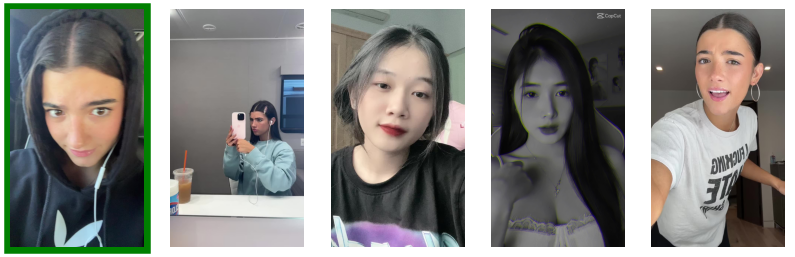

In [18]:
run_adaptive_beam_search()

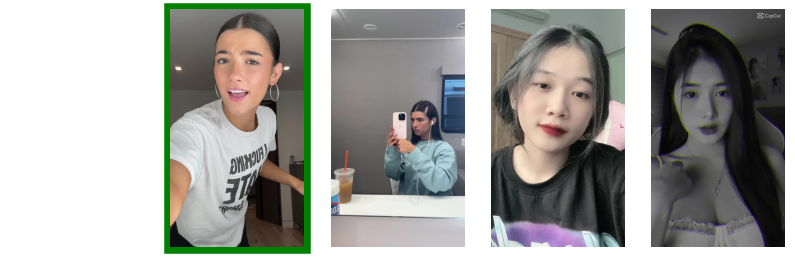

In [19]:
run_adaptive_beam_search()

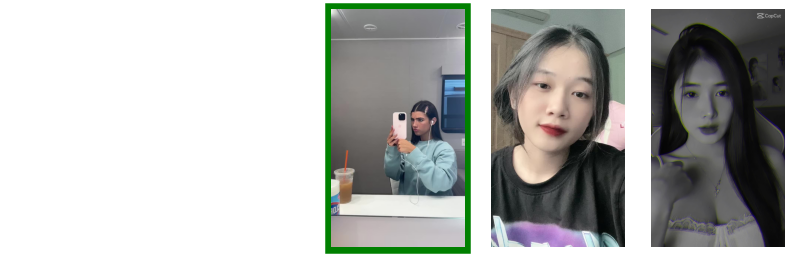

In [20]:
run_adaptive_beam_search()

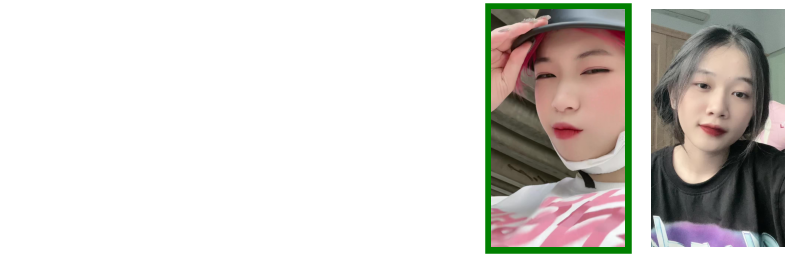

In [21]:
run_adaptive_beam_search()

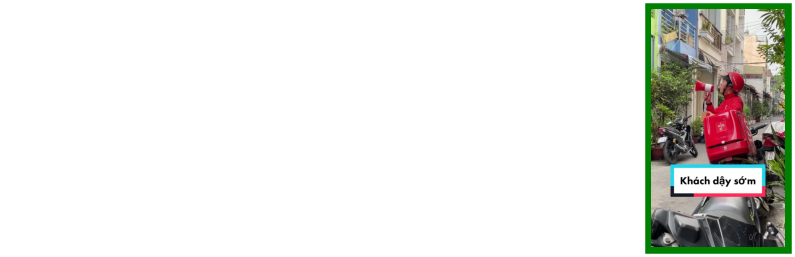

In [22]:
run_adaptive_beam_search()